In [1]:
## Import

In [2]:
import wntr
import networkx as nx
import scipy.sparse as sp
import numpy as np 
import random
import tqdm
import os 
import matplotlib.pyplot as plt
import itertools
from collections import Counter 
import networkx as nx
import copy
import pandas as pd
import tensorflow_gnn as tfgnn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
## Import network

In [4]:
network = 'stkl_no_control'
inp_file = network + '.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

In [5]:
wn = wntr.network.WaterNetworkModel(inp_file)  # reset value
wn.options.hydraulic.demand_model = 'DD' #dynamic demand model
results = wntr.sim.EpanetSimulator(wn).run_sim(version=2.0)
head = results.node['head']
demand = results.node['demand']
demand = np.maximum(demand, 0)
num_nodes = wn.num_nodes

In [6]:
timesteps = demand.index.tolist()

In [7]:
num_nodes

1106

In [8]:
monitor_point = pd.read_excel('Monitor_points.xlsx')
monitor_b = monitor_point['Branch point'].sample(n= 150, random_state=42)
monitor_point = pd.read_excel('Area_point.xlsx')
monitor_a = monitor_point['Area point'].sample(n= 348, random_state=42)

In [9]:
monitor = monitor_a.append(monitor_b, ignore_index=True)
print(monitor)

0       841
1      2629
2      2109
3      2382
4      2532
       ... 
493     521
494     506
495     588
496    2620
497      87
Length: 498, dtype: int64


C:\Users\TianZhang\AppData\Local\Temp\ipykernel_22356\1897181280.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  monitor = monitor_a.append(monitor_b, ignore_index=True)


In [10]:
# Calculate the total number of timesteps
num_timesteps = len(timesteps)

# Initialize the 3-dimensional array 'A' to store link information
num_links = wn.num_links
A = np.zeros((num_timesteps, num_links, 4))

# Outer loop to go through each timestep in the sequence
for timestep_idx in range(num_timesteps):
    # Inner loop to go through each link in the water network
    for i, (_, link) in enumerate(wn.links()):
        # Extract the numeric part of the node names using string manipulation
        start_node_name = link.start_node.name
        end_node_name = link.end_node.name
        A[timestep_idx, i, 0] =float( start_node_name[-4:])
        A[timestep_idx, i, 1] = float(end_node_name[-4:])
        A[timestep_idx, i, 2] = float(link.name[-4:])
        # Access loss coefficient from the DataFrame 'loss_co'
        if link.link_type=='Pipe':
            A[timestep_idx, i, 3] = 1/(10.667*link.length/link.roughness**1.852/link.diameter**4.871)
            i+=1
        elif link.link_type=='Pump':
            A[timestep_idx, i, 3] = 1        
        elif link.link_type=='Valve':
            A[timestep_idx, i, 3] = 2        
        else:
            print('Other types of links exist.')

# After the loops, 'A' will contain the required link information for each timestep

In [11]:
num_nodes = wn.num_nodes
B = np.zeros((num_timesteps, num_nodes, 6))

Node_indicator = np.tile(np.arange(1, num_nodes+1), num_timesteps)
Nd_single = np.array([0 if node.node_type=='Junction' and node.name not in monitor
                   else 1 for _,node in wn.nodes()])
Nd = np.tile(Nd_single,num_timesteps)
Nd = Nd.squeeze()
#### Measurement indicator (if the node has head, measurement indicator = 1) (fully-supervised, all 1)
Nh_single = np.zeros(num_nodes)
Nh = np.tile(Nh_single,num_timesteps)
Nh = Nh.squeeze()

for timestep_idx in range(num_timesteps):

    for i, (_, node) in enumerate(wn.nodes()):
        B[timestep_idx, i, 0] = timesteps[timestep_idx]
        B[timestep_idx, i, 1] = float(node.name[-4:])
        B[timestep_idx, i, 2] = Nd[i]
        B[timestep_idx, i, 3] = demand.iloc[timestep_idx][i]*3.6
        B[timestep_idx, i, 4] = Nh[i]
        B[timestep_idx, i, 5] = head.iloc[timestep_idx][i]

In [12]:
U = np.zeros((num_timesteps, num_nodes, 2))
timestep_idx = 0
for timestep_idx in range(num_timesteps):
    for i, (_, node) in enumerate(wn.nodes()):
        U[timestep_idx, i, 0] = float(node.name[-4:])
        U[timestep_idx, i, 1] = head.iloc[timestep_idx][i]

In [13]:
array_3d_shape = B.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
B_2d = B.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
node_df = pd.DataFrame(B_2d)

array_3d_shape = A.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
A_2d = A.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
edge_df = pd.DataFrame(A_2d)

array_3d_shape = U.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
U_2d = U.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
head_df = pd.DataFrame(U_2d)

In [14]:
head_df.rename(columns={0: 'Node_indicator',1: 'head'},inplace=True)
edge_df.rename(columns={0: 'source', 1: 'target', 2:'link_name',3: 'loss_co'},inplace=True)
node_df.rename(columns={0:'Time_indicator', 1: 'Node_indicator', 2:'Junction_in',3: 'demand', 4: 'Measurement_in',5:'measurement'},inplace=True)

In [15]:
node_df_copy = node_df.copy()

# Get the indices where Node_indicator is not in the monitor array
monitor_indices = node_df_copy.loc[~node_df_copy['Node_indicator'].isin(monitor)].index
nmonitor_indices = node_df_copy.loc[node_df_copy['Node_indicator'].isin(monitor)].index
# Set measurement to 0 for rows where Node_indicator is not in the monitor array
node_df_copy.loc[monitor_indices, 'measurement'] = 0
node_df_copy.loc[nmonitor_indices, 'Measurement_in'] = 1
# Display the modified DataFrame
print(node_df_copy)

        Time_indicator  Node_indicator  Junction_in    demand  Measurement_in  \
0                  0.0             1.0          0.0  0.000041             1.0   
1                  0.0             3.0          0.0  0.000023             1.0   
2                  0.0             4.0          0.0  0.000014             0.0   
3                  0.0             5.0          0.0  0.000069             1.0   
4                  0.0             6.0          0.0  0.000100             0.0   
...                ...             ...          ...       ...             ...   
107277         86400.0          2676.0          0.0  0.000082             0.0   
107278         86400.0          2677.0          0.0  0.000014             1.0   
107279         86400.0          2744.0          0.0  0.000085             1.0   
107280         86400.0          2745.0          0.0  0.000014             0.0   
107281         86400.0             1.0          1.0  0.000000             1.0   

        measurement  
0    

In [16]:
edge_df.to_csv('edge_df.csv')
node_df_copy.to_csv('node_df_copy.csv')
head_df.to_csv('head_df.csv')

In [17]:
# Edge
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
column_to_scale = 'loss_co'

## Fit and transform the selected column
edge_df[column_to_scale] = scaler.fit_transform(edge_df[[column_to_scale]])
#
# Node
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['demand', 'measurement']

# Fit and transform the selected columns
node_df_copy[columns_to_scale] = scaler.fit_transform(node_df_copy[columns_to_scale])
#

# Graph
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['head']

# Fit and transform the selected columns
head_df[columns_to_scale] = scaler.fit_transform(head_df[columns_to_scale])


In [18]:
test_edge_df = edge_df[num_links * (num_timesteps - 34):]
test_node_df = node_df_copy[num_nodes * (num_timesteps - 34):]
test_head_df = head_df[num_nodes * (num_timesteps - 34):]

train_edge_df = edge_df[: num_links * (num_timesteps - 60)]
train_node_df = node_df_copy[: num_nodes * (num_timesteps - 60)]
train_head_df = head_df[: num_nodes * (num_timesteps - 60)]

vali_edge_df = edge_df[ num_links * (num_timesteps - 60): num_links * (num_timesteps - 34)]
vali_node_df = node_df_copy[ num_nodes * (num_timesteps - 60): num_nodes * (num_timesteps - 34)]
vali_head_df = head_df[ num_nodes * (num_timesteps - 60): num_nodes * (num_timesteps - 34)]

In [19]:
def create_graph_tensor(node_df, edge_df,head_df):
    graph_tensor = tfgnn.GraphTensor.from_pieces(

        node_sets={
            "node": tfgnn.NodeSet.from_fields(
                sizes=[len(node_df)],
                features={
                    #'Node_indicator':np.array(node_df['Node_indicator'], dtype='int32').reshape(len(node_df),1),
                    'Junction_in':np.array(node_df['Junction_in'], dtype='int32').reshape(len(node_df),1),
                    'demand': np.array(node_df['demand'], dtype='float32').reshape(len(node_df),1),
                    'Measurement_in': np.array(node_df['Measurement_in'], dtype='int32').reshape(len(node_df),1),
                    'measurement': np.array(node_df['measurement'], dtype='float32').reshape(len(node_df),1),
                    'head': np.array(head_df['head'], dtype='float32').reshape(len(head_df),1),
                }
            )
        },
        edge_sets={
            "link": tfgnn.EdgeSet.from_fields(
                sizes=[len(edge_df)],
                features={
                    'loss_co': np.array(edge_df['loss_co'], dtype='float32').reshape(len(edge_df),1),
                   # 'flowrate': np.array(edge_df['flowrate'], dtype='float32').reshape(len(edge_df),1),
                },
                adjacency=tfgnn.Adjacency.from_indices(
                                          source=("node", np.array(edge_df['source'], dtype='int32')),
                                          target=("node", np.array(edge_df['target'], dtype='int32')),
                                      ))
        }
    )

    return graph_tensor


In [20]:
full_tensor = create_graph_tensor(node_df_copy, edge_df,head_df)
train_tensor = create_graph_tensor(train_node_df, train_edge_df, train_head_df)
test_tensor = create_graph_tensor(test_node_df, test_edge_df, test_head_df)
vali_tensor = create_graph_tensor(vali_node_df, vali_edge_df, vali_head_df)

In [21]:
def node_batch_merge(graph):
    graph = graph.merge_batch_to_components()
    node_features = graph.node_sets['node'].get_features_dict()
    edge_features = graph.edge_sets['link'].get_features_dict()
    
    label = node_features.pop('head')
    print(label)
    new_graph = graph.replace_features(node_sets={'node': node_features}, edge_sets={'link': edge_features})
    
    return new_graph, label


     
def create_dataset(graph, function):
    dataset = tf.data.Dataset.from_tensors(graph)
    dataset = dataset.batch(32)
    return dataset.map(function)

In [22]:
full_node_dataset = create_dataset(full_tensor, node_batch_merge)
train_node_dataset = create_dataset(train_tensor, node_batch_merge)
test_node_dataset = create_dataset(test_tensor, node_batch_merge)
vali_node_dataset = create_dataset(vali_tensor, node_batch_merge)

Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)


In [23]:
graph_spec = train_node_dataset.element_spec[0]
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

In [24]:
def set_initial_node_state(node_set, node_set_name):
    features = [
        #tf.keras.layers.Dense(32, activation="relu")(node_set['Node_indicator']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Junction_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['demand']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Measurement_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['measurement']),
    ]
    return tf.keras.layers.Concatenate()(features)


def set_initial_edge_state(edge_set, edge_set_name):
    features = [
        tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['loss_co']),
        #tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['flowrate']),
    ]
    return tf.keras.layers.Concatenate()(features)




In [25]:
def dense_layer(units=128, l2_reg=0.01, dropout=0.5, activation='tf.nn.leaky_relu'):
    regularizer = tf.keras.regularizers.l2(l2_reg)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, kernel_initializer='glorot_normal',kernel_regularizer=regularizer, bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout)
    ])
graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=set_initial_node_state,
                                       edge_sets_fn=set_initial_edge_state)(input_graph)

In [26]:
graph_updates = 6
l2_reg = 0.01
regularizer = tf.keras.regularizers.l2(l2_reg)
for i in range(graph_updates):
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            'node':
            tfgnn.keras.layers.NodeSetUpdate(
                {
                    'link':
                    tfgnn.keras.layers.SimpleConv(message_fn=dense_layer(128),
                                                  reduce_type="mean",
                                                  sender_edge_feature=tfgnn.HIDDEN_STATE,
                                                  receiver_tag=tfgnn.TARGET)
                }, tfgnn.keras.layers.NextStateFromConcat(dense_layer(64)))
        })(graph)
    dense1 = tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)(graph.node_sets["node"][tfgnn.HIDDEN_STATE])
    dense2 = tf.keras.layers.Dense(64)(dense1)
    dense3 = tf.keras.layers.Dense(64)(dense2)
    dense4 = tf.keras.layers.Dense(1)(dense3)

In [27]:
node_model = tf.keras.Model(input_graph, dense4)
node_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss='mean_squared_error',
                   metrics=['mean_squared_error'])
node_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 map_features (MapFeatures)  ()                        320       
                                                                 
 graph_update (GraphUpdate)  ()                        53440     
                                                                 
 graph_update_1 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_2 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_3 (GraphUpdate  ()                       32960 

In [29]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                      mode='min',
                                      verbose=10,
                                      patience=10,
                                      restore_best_weights=True)

node_model.fit(full_node_dataset.repeat(),
               validation_data=full_node_dataset,
               steps_per_epoch=10,
               epochs=200,
               callbacks=[es])

Epoch 1/200
10/10 [==============================] - 19s 2s/step - loss: 0.6126 - mean_squared_error: 0.5624 - val_loss: 0.6970 - val_mean_squared_error: 0.6480
Epoch 2/200
10/10 [==============================] - 21s 2s/step - loss: 0.6477 - mean_squared_error: 0.5960 - val_loss: 0.5994 - val_mean_squared_error: 0.5452
Epoch 3/200
10/10 [==============================] - 21s 2s/step - loss: 0.6143 - mean_squared_error: 0.5582 - val_loss: 0.5853 - val_mean_squared_error: 0.5290
Epoch 4/200
10/10 [==============================] - 21s 2s/step - loss: 0.6058 - mean_squared_error: 0.5515 - val_loss: 0.5795 - val_mean_squared_error: 0.5271
Epoch 5/200
10/10 [==============================] - 21s 2s/step - loss: 0.6008 - mean_squared_error: 0.5494 - val_loss: 0.5763 - val_mean_squared_error: 0.5263
Epoch 6/200
10/10 [==============================] - 23s 2s/step - loss: 0.5990 - mean_squared_error: 0.5490 - val_loss: 0.5778 - val_mean_squared_error: 0.5280
Epoch 7/200
10/10 [===============

In [30]:
predictions = pd.DataFrame(node_model.predict(full_node_dataset))
correlation = head_df['head'].corr(predictions[0])
print(correlation)
print(predictions)

1/1 [==============================] - 1s 791ms/step
0.6893698397138092
               0
0       1.337498
1       1.503644
2      -0.031866
3       1.458632
4       1.104648
...          ...
107277 -0.207425
107278  0.955806
107279  0.800361
107280 -0.031866
107281  1.373852

[107282 rows x 1 columns]


In [31]:
predictions[0]

0         1.337498
1         1.503644
2        -0.031866
3         1.458632
4         1.104648
            ...   
107277   -0.207425
107278    0.955806
107279    0.800361
107280   -0.031866
107281    1.373852
Name: 0, Length: 107282, dtype: float32

In [32]:
head_df = pd.read_csv('head_df.csv')
edge_df = pd.read_csv('edge_df.csv')
node_df = pd.read_csv('node_df_copy.csv')

In [33]:
mean_n = head_df['head'].mean()
std_n = head_df['head'].std()


In [34]:
Pre = (predictions *std_n)+mean_n
print(Pre)
correlation = head_df['head'].corr(Pre[0])
print(correlation)
residuals =  head_df['head']- (Pre[0])

                0
0       86.280609
1       86.838661
2       81.681213
3       86.687469
4       85.498520
...           ...
107277  81.091553
107278  84.998589
107279  84.476486
107280  81.681213
107281  86.402718

[107282 rows x 1 columns]
0.6893698481759241


In [35]:
Pre.to_csv('45%-L.csv')

In [36]:
residuals

0        -0.007881
1        -0.819473
2         4.349472
3        -0.636589
4         0.530334
            ...   
107277    3.786789
107278   -0.121056
107279    0.416153
107280    4.340469
107281    0.652184
Length: 107282, dtype: float64

In [37]:
ana = pd.DataFrame({
    'node':node_df['Node_indicator'],
    'predictions': predictions[0],
    'residuals': residuals
})
Pre_array =  np.array(Pre).reshape((-1, num_nodes,1))
Pre_array = np.mean(Pre_array, axis=2)
Pre_ana = pd.DataFrame(Pre_array, columns=['Node ' + str(i+1) for i in range(num_nodes)])
Pre_ana['Node 5']

0     85.498520
1     81.054260
2     81.095085
3     81.102844
4     81.172363
        ...    
92    80.747620
93    80.769554
94    80.817772
95    80.886925
96    80.961006
Name: Node 5, Length: 97, dtype: float32

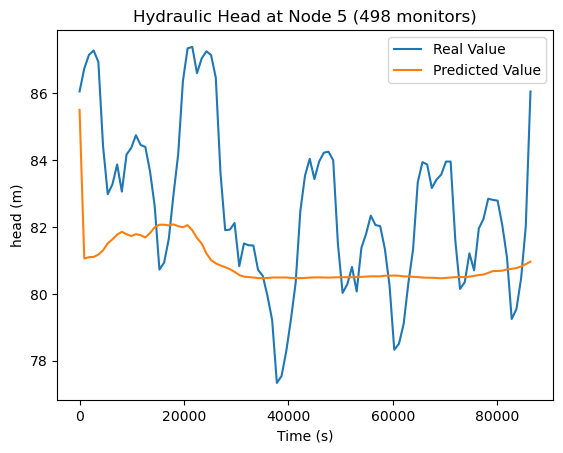

In [46]:
head_at_node5 = head.loc[:,'node_0005']
ax = head_at_node5.plot()
ax.set_xlabel("Time (s)")
ax.set_ylabel("head (m)")
Pre_ana = Pre_ana.set_index(head.index)

Pre_ana['Node 5'].plot(ax=ax)
plt.title('Hydraulic Head at Node 5 (498 monitors)')
plt.legend(['Real Value', 'Predicted Value'])
plt.savefig('Hydraulic Head at Node 5 (498 monitors).png')
plt.show()

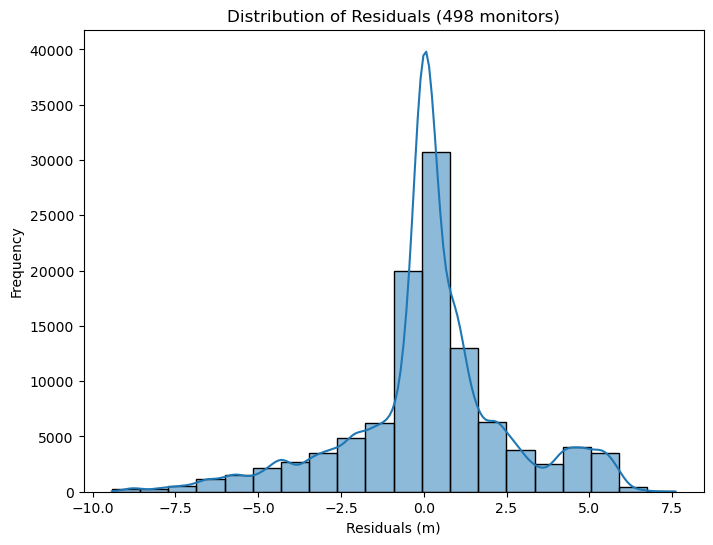

In [39]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(residuals, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.title('Distribution of Residuals (498 monitors)')
plt.savefig('Distribution of Residuals (498 monitors).png')
plt.show()

In [40]:
RESI = ana[ana['node'].isin(monitor)]['residuals']
Other_RESI = ana[~ana['node'].isin(monitor)]['residuals']

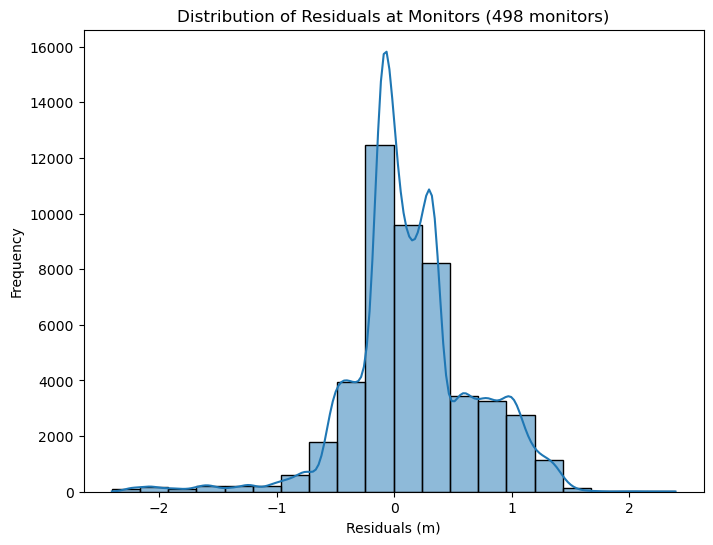

In [41]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(RESI, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals at Monitors (498 monitors)')

plt.savefig('Distribution of Residuals at Monitors (498 monitors).png')
plt.show()

In [ ]:
new_value = pd.Series([3000])

# Concatenate the two Series
monitor = pd.concat([monitor, new_value], ignore_index=True)
RESI = np.array(RESI).reshape((-1, 221))
RESI_df = pd.DataFrame(RESI[:221], columns=['Node ' + str(i) for i in monitor])
RESI_df.rename(columns={'Node 3000': 'Reservoir 1'}, inplace=True)

In [42]:
residuals.max()

7.601470947265625

In [43]:
residuals.min()

-9.417381286621094

In [44]:
RESI.max()

2.3919830322265625

In [45]:
RESI.min()

-2.4032974243164062

In [16]:
Pre = pd.read_csv('45%-L.csv')

In [17]:
Pre = pd.read_csv('45%-L.csv')
residuals =  head_df['head']- (Pre['0'])

In [23]:
# Create an empty DataFrame with two columns
link_graph_df = pd.DataFrame(columns=["start_node", "end_node"])
edge_l = edge_df.iloc[:num_links]
link

,source,target,link_name,loss_co
0,1.0,844.0,1.0,0.001301
1,3.0,870.0,3.0,0.006332
2,4.0,524.0,4.0,0.027062
3,6.0,2362.0,5.0,0.000451
4,7.0,828.0,6.0,0.002274
...,...,...,...,...
1129,1942.0,1943.0,2813.0,2.000000
1130,1944.0,1945.0,2814.0,2.000000
1131,1946.0,1947.0,2815.0,2.000000
1132,1948.0,1949.0,2816.0,2.000000


In [41]:
head_df

,Node_indicator,head
0,1.0,86.272728
1,3.0,86.019188
2,4.0,86.030685
3,5.0,86.050880
4,6.0,86.028854
...,...,...
107277,2676.0,84.878342
107278,2677.0,84.877533
107279,2744.0,84.892639
107280,2745.0,86.021683


In [24]:
link_graph_df['start_node'] = edge_l['source']
link_graph_df['end_node'] = edge_l['target']

In [46]:
residuals_a = residuals.abs()
residuals_array =  np.array(residuals_a).reshape((-1, num_nodes))
reshaped_ana = pd.DataFrame(residuals_array, columns=['Node ' + str(i+1) for i in range(num_nodes)])
mean_residuals = reshaped_ana.mean()
mean_residuals.index = head_df.iloc[:num_nodes, 0]

In [52]:
mean_residuals = mean_residuals.iloc[:-1]


C:\Users\TianZhang\AppData\Local\Temp\ipykernel_22356\2052683172.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Mean Residuals', orientation='vertical')


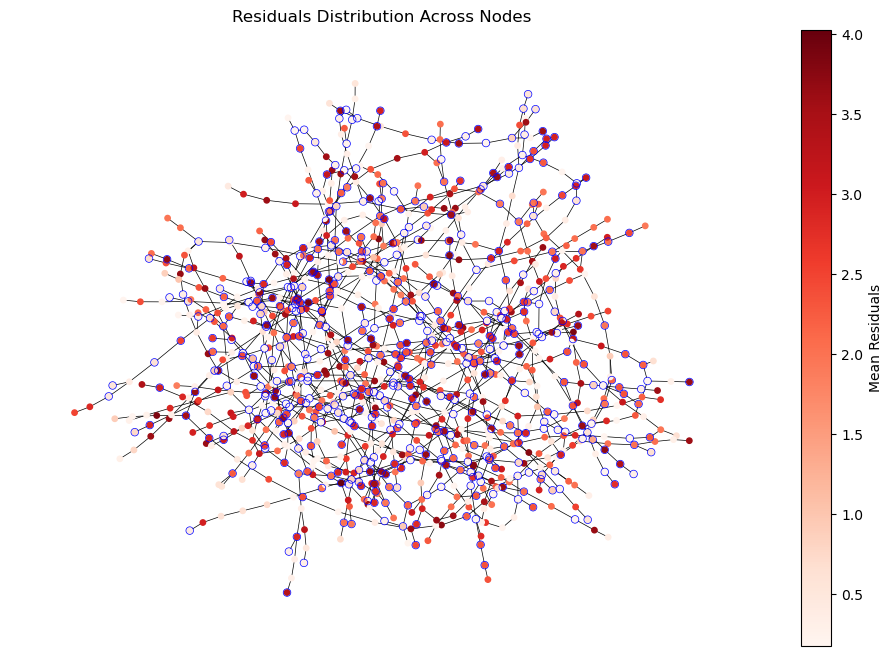

In [102]:
# 从DataFrame创建一个边列表
edges = list(zip(link_graph_df['start_node'], link_graph_df['end_node']))
G = nx.Graph()
# Convert float monitor nodes to string format
string_monitor = ['Node ' + str(int(node)) for node in monitor]

# Extract color values for monitor nodes
monitor_colors = [mean_residuals[node] for node in string_monitor if node in mean_residuals]

plt.figure(figsize=(12, 8))
ax = plt.gca()

G.add_edges_from(edges)

cmap = plt.get_cmap('Reds')  # 使用'Reds' colormap，你可以更换为其他的colormap
normed_residuals = (mean_residuals - np.min(mean_residuals)) / (np.max(mean_residuals) - np.min(mean_residuals))  # 归一化到[0, 1]范围
colors = [cmap(val) for val in normed_residuals]
pos = nx.spring_layout(G)

# 为所有节点绘制颜色
nx.draw_networkx_nodes(G, pos, node_size=15,label = False, node_color=colors, cmap=plt.cm.Reds, ax=ax)
# 为float_monitor节点绘制颜色，并加上黑色边框
nx.draw_networkx_nodes(G, pos, node_size=30,nodelist=monitor, node_color=monitor_colors, cmap=plt.cm.Reds, edgecolors='blue', linewidths= 0.5, ax=ax)
nx.draw_networkx_edges(G, pos, ax=ax, width = 0.5)

plt.title("Residuals Distribution Across Nodes")
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=min(mean_residuals), vmax=max(mean_residuals)))
sm.set_array([])
plt.colorbar(sm, label='Mean Residuals', orientation='vertical')
plt.axis('off')
plt.show()

In [75]:

ana = pd.DataFrame({
    'node':node_df['Node_indicator'],
    'predictions': Pre['0'],
    'residuals': residuals
})
RESI = ana[ana['node'].isin(monitor)]['residuals']

In [76]:
RESI.abs().min()

5.808105470350711e-06

In [77]:
RESI.abs().max()

2.4032974057617196

In [86]:
residuals.abs().min()

5.808105470350711e-06

In [87]:
residuals.abs().max()

9.417384047851556

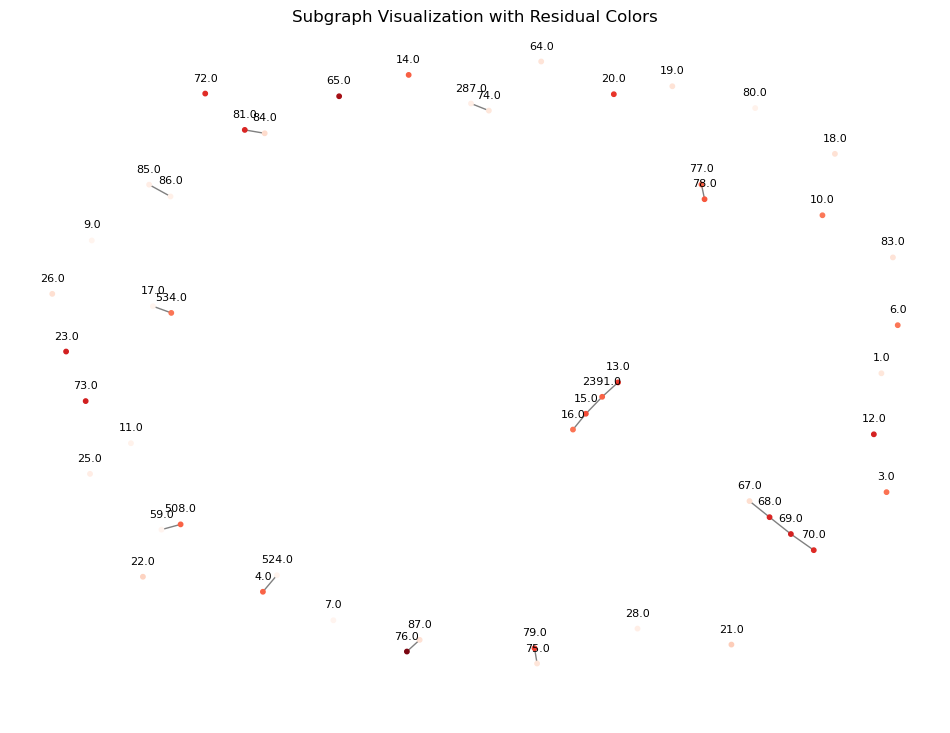

In [118]:
# 假设你的图是G
node_colors_in_G = [colors[list(G.nodes()).index(node)] for node in G.nodes()]

# 按度中心性排序节点并选择前100个
central_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:50]

subgraph = G.subgraph(central_nodes)

# 为子图中的节点获取颜色
node_colors_in_subgraph = [node_colors_in_G[list(G.nodes()).index(node)] for node in subgraph.nodes()]

plt.figure(figsize=(12, 9))

# 使用spring_layout计算节点位置
pos = nx.spring_layout(subgraph)

# 计算标签位置（这里，我们将每个标签在 y 方向上移动0.05个单位）
label_pos = {node: (x, y+0.05) for node, (x, y) in pos.items()}

# 绘制图形和边
nx.draw_networkx(subgraph, pos, node_color=node_colors_in_subgraph, edge_color='gray', node_size=10, with_labels=False)

# 绘制标签，设置大小为10
nx.draw_networkx_labels(subgraph, label_pos, font_size=8)
plt.title("Subgraph Visualization with Residual Colors")
plt.axis('off')
plt.show()
